<a href="https://colab.research.google.com/github/AnaliaLeyez/AnaliaLeyez/blob/main/ej_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ARIMA**

Los modelos **ARIMA** (AutoRegressive Integrated Moving Average) son una clase de modelos muy utilizada para analizar y predecir series temporales.
Los modelos ARIMA se aplican cuando se necesita capturar patrones de dependencia temporal (autocorrelación) en los datos y obtener predicciones futuras basadas en la estructura histórica de la serie.

ARIMA es un modelo que combina tres componentes principales:

* AR (AutoRegressive): La parte autorregresiva del modelo indica que los valores actuales de la serie pueden ser explicados a partir de los valores anteriores de la serie, en una cantidad específica de rezagos (o lags).
* I (Integrated): La parte de integración se refiere a la diferencia entre valores sucesivos para hacer que la serie sea estacionaria, lo cual significa que sus propiedades estadísticas no cambian con el tiempo. Este proceso de diferenciación ayuda a eliminar tendencias.
* MA (Moving Average): La parte de media móvil incorpora la relación entre el valor actual de la serie y los errores pasados (ruido) para suavizar y capturar el comportamiento de la serie.

Un modelo ARIMA se denota como ARIMA(p, d, q), donde:
* p es el número de términos autorregresivos (AR).
* d es el número de diferencias requeridas para hacer estacionaria la serie.
* q es el número de términos de media móvil (MA).





**Pruebas y transformaciones necesarias antes de utilizar un modelo ARIMA**

Para aplicar un modelo ARIMA correctamente, es necesario realizar una serie de pruebas y transformaciones que ayudan a identificar los valores óptimos de p, d y q.

**Prueba de estacionariedad:**

La estacionariedad es fundamental para los modelos ARIMA, ya que estos requieren una serie con propiedades estadísticas constantes a lo largo del tiempo.

* Prueba de Dickey-Fuller aumentada (ADF): Esta prueba ayuda a determinar si la serie es estacionaria o no. Un p-valor bajo (menor a 0.05) sugiere que la serie es estacionaria. Si no es estacionaria, se aplican diferencias (diferenciación) para hacerla estacionaria.


**Transformación: Diferenciación:**

Si la serie no es estacionaria, se diferencia para remover la tendencia y hacerla estacionaria. Esto implica restar el valor actual del valor anterior.
El valor de d en ARIMA(p, d, q) indica cuántas veces se debe diferenciar la serie. Se comienza con d=1 y se verifica si la serie se vuelve estacionaria. Si no lo es, se intenta con d=2, y así sucesivamente.


**Transformaciones adicionales (si es necesario):**

Si la serie tiene heterocedasticidad (varianza cambiante), puede ser útil aplicar una transformación logarítmica o una raíz cuadrada para estabilizar la varianza.
Estas transformaciones no afectan la estacionariedad, pero ayudan a reducir la variabilidad.


**Gráfico de Autocorrelación (ACF) y Gráfico de Autocorrelación Parcial (PACF):**

Estos gráficos ayudan a identificar los posibles valores de p y q.

En el gráfico ACF, se observa si hay autocorrelaciones significativas en los primeros rezagos (lags), lo que puede indicar un valor para q.

En el gráfico PACF, observa la cantidad de rezagos significativos para determinar el valor de p.





**Ejemplo del proceso para ajustar un modelo ARIMA**

1) Revisión de estacionariedad: Primero, aplica la prueba de Dickey-Fuller a la serie. Si no es estacionaria, aplicar una diferenciación y repitir la prueba hasta lograr estacionariedad.

2) Análisis de gráficos ACF y PACF: Luego de obtener una serie estacionaria, observar los gráficos ACF y PACF para elegir posibles valores de p y q.

3) Prueba de modelos y evaluación: Probar varias combinaciones de p, d y q.

4) Evaluación de residuos: Una vez ajustado el modelo, revisar los residuos para asegurarse que se comporten como ruido blanco (sin patrones, media cero y varianza constante).

In [ ]:
# importamos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
# Crear un DataFrame de ejemplo con más variabilidad
np.random.seed(0)
data = {
    'Fecha': pd.date_range(start='2025-01-01', periods=200, freq='D'),
    'Valor': np.random.normal(loc=0.0, scale=1.0, size=200).cumsum() + np.linspace(0, 10, 200)
}
df = pd.DataFrame(data)
df.set_index('Fecha', inplace=True)


In [ ]:
!pip install pycoingecko pmdarima --quiet

from pycoingecko import CoinGeckoAPI

# Descargar precios históricos de Bitcoin
cg = CoinGeckoAPI()

# Rango: 365 días (~1 año)
data = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days=365)

# CoinGecko devuelve timestamps en milisegundos → convertir a fecha
prices = pd.DataFrame(data['prices'], columns=['timestamp', 'Valor'])
prices['Fecha'] = pd.to_datetime(prices['timestamp'], unit='ms')
prices.drop('timestamp', axis=1, inplace=True)
prices.set_index('Fecha', inplace=True)

# Renombrar para seguir con el flujo
df = prices.copy()  # df tendrá índice de fechas y columna 'Valor'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.3 MB/s eta 0:00:00


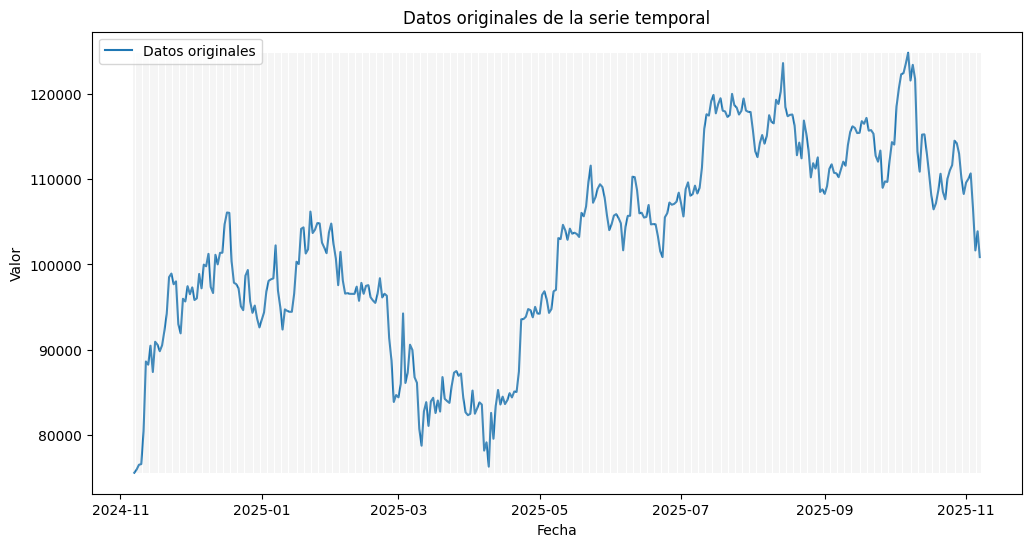

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Valor'], label='Datos originales')
plt.vlines(df.index, ymin=min(df['Valor']), ymax=max(df['Valor']), color='lightgray', linewidth=0.3)

plt.title('Datos originales de la serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


**Pruebas de Estacionariedad**

La prueba de Dickey-Fuller aumentada (ADF) se usa para verificar la estacionariedad de la serie temporal.



Para que una serie sea estacionaria, el valor de la estadística ADF debe ser menor que los valores críticos a diferentes niveles de significancia (1%, 5%, 10%). Además, un p-valor bajo (menor a 0.05) indica que SE PODRÍA rechazar la hipótesis nula de que la serie no es estacionaria.

* ADF Statistic (Differenced): Este valor es el estadístico de la prueba Dickey-Fuller aumentada. Cuanto más negativo sea este valor, mayor será la evidencia contra la hipótesis nula de que existe una raíz unitaria (indicando no estacionariedad).

* p-value (Differenced): Este p-valor te ayuda a determinar si puedes rechazar la hipótesis nula. Si el valor es menor a 0.05, tienes evidencia suficiente para rechazar la hipótesis nula y afirmar que la serie es estacionaria.

* Critical Values (Differenced): Son los valores críticos en los niveles de significancia del 1%, 5% y 10%. Si el ADF Statistic es menor que estos valores, puedes rechazar la hipótesis nula y concluir que la serie es estacionaria.

La diferenciación es útil cuando la serie original no es estacionaria, pero puede serlo después de aplicar una o más diferencias.

In [ ]:
result = adfuller(df['Valor'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value ({}):'.format(key), value)


ADF Statistic: -2.5928096350256378
p-value: 0.09449249484237954
Critical Value (1%): -3.4483935212959844
Critical Value (5%): -2.8694912343676497
Critical Value (10%): -2.571005879151811


In [ ]:
df

In [ ]:
# Diferenciar la serie temporal
df['Valor_Diff'] = df['Valor'].diff().fillna(0)

In [ ]:
df

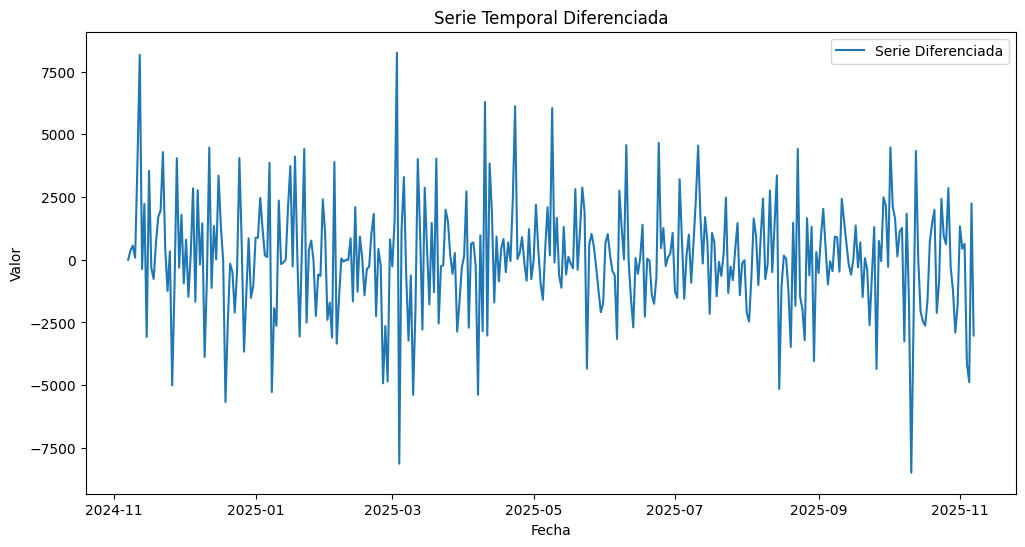

In [ ]:
# Graficar la serie temporal después de la diferenciación
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Valor_Diff'], label='Serie Diferenciada')
plt.title('Serie Temporal Diferenciada')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
# Prueba de Dickey-Fuller después de la diferenciación
result_diff = adfuller(df['Valor_Diff'])
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
for key, value in result_diff[4].items():
    print('Critical Value (Differenced) ({}):'.format(key), value)


ADF Statistic (Differenced): -19.852552767647
p-value (Differenced): 0.0
Critical Value (Differenced) (1%): -3.4483935212959844
Critical Value (Differenced) (5%): -2.8694912343676497
Critical Value (Differenced) (10%): -2.571005879151811


Identificación de p y q

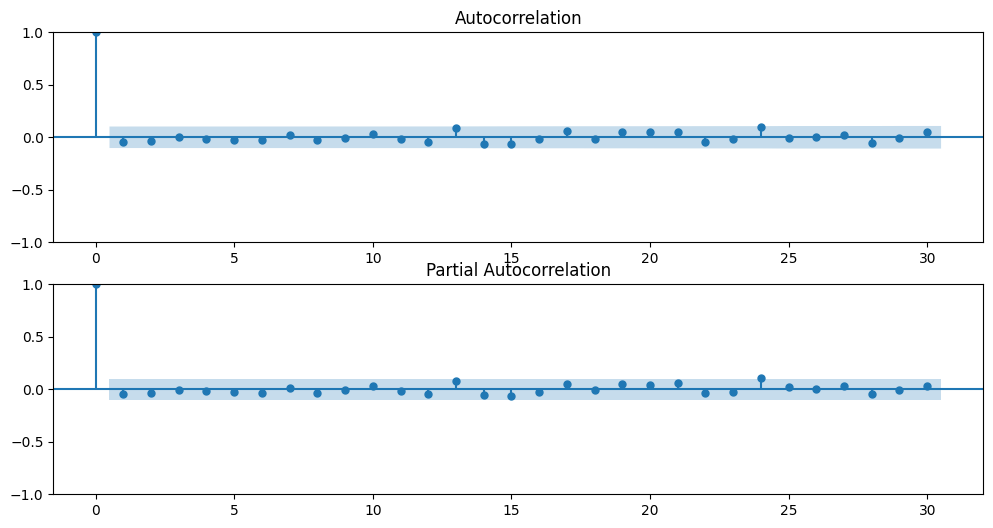

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Valor_Diff'], ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(df['Valor_Diff'], ax=plt.gca(), lags=30)
plt.show()


El gráfico de autocorrelación es una herramienta que ayuda a entender si existe correlación entre los valores diferenciados de la serie en distintos rezagos (lags).

Eje Y (Autocorrelación): Este eje muestra los valores de la función de autocorrelación (ACF), que varían entre -1 y 1. Estos valores indican cuánta correlación hay entre el valor actual de la serie diferenciada y sus valores anteriores en diferentes rezagos.

Eje X (Lags o Rezagos): Cada punto en el eje X representa un rezago, desde el primer rezago hasta el número de lags especificado, en este caso, hasta 30. Esto significa que el gráfico muestra la correlación de Valor_Diff con su valor de 1 paso atrás, 2 pasos atrás, etc., hasta el rezago 30.

Barras de Correlación: Cada barra representa el valor de la autocorrelación para un rezago específico. Las barras que sobresalen por encima o por debajo de las líneas de significancia indican una correlación significativa entre los valores diferenciados de la serie a ese rezago.

Líneas de Significancia (líneas punteadas): Estas líneas marcan el intervalo de confianza para la autocorrelación. Si una barra de autocorrelación se encuentra fuera de estas líneas, se considera que la correlación en ese rezago es estadísticamente significativa (generalmente al nivel del 95%).

Interpretación del Patrón:

Si los valores de autocorrelación caen rápidamente a cero (es decir, las barras caen dentro de las líneas de significancia después de unos pocos rezagos), esto sugiere que la serie diferenciada es estacionaria.

Si existe un patrón decreciente o un comportamiento oscilante que cae dentro de las bandas de significancia, esto también es un buen indicio de estacionariedad.

Si, por otro lado, hay una correlación significativa en varios rezagos, podría indicar que persiste alguna estacionalidad o dependencia en la serie diferenciada.

Conclusión

Un gráfico ACF de una serie diferenciada ayuda a verificar si la diferenciación fue efectiva para remover tendencias y hacer la serie estacionaria. Si el gráfico muestra correlación significativa solo en algunos rezagos (por ejemplo, en el rezago 1 y algunos menores), es probable que la serie diferenciada ya sea estacionaria, lo cual es un buen indicador para continuar con el análisis de modelos ARIMA o similares.

Ajuste del modelo ARIMA
Basándonos en las gráficas ACF y PACF, elegimos los valores de p y q.

In [ ]:
# Ajustar el modelo ARIMA
model = ARIMA(df['Valor'], order=(1, 1, 1))  # Ejemplo con (p=1, d=1, q=1)
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3331.146
Date:                Thu, 06 Nov 2025   AIC                           6668.293
Time:                        21:52:16   BIC                           6679.992
Sample:                             0   HQIC                          6672.942
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1442      4.756      0.030      0.976      -9.177       9.465
ma.L1         -0.1538      4.746     -0.032      0.974      -9.457       9.149
sigma2      4.951e+06   2.72e+05     18.179      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Diagnóstico del modelo
Verificamos los residuos del modelo para asegurarnos de que sean ruido blanco

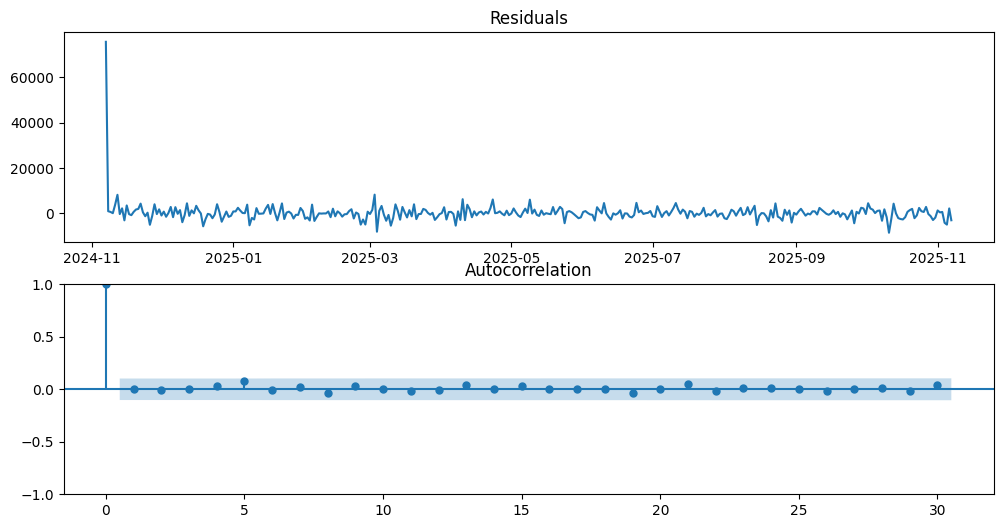

In [ ]:
# Diagnóstico de residuos
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plot_acf(residuals, ax=plt.gca(), lags=30)
plt.show()


Los residuos representan la "parte no explicada" por el modelo y se calculan como:

residuo =valor observado - valor predicho

Por lo tanto, si el modelo ha capturado bien la estructura de la serie, los residuos deberían comportarse como ruido blanco: deben ser valores aleatorios y sin correlación, con una media cercana a cero y varianza constante.

¿Para qué se utilizan los residuos?

Evaluar la calidad del modelo: verificar si el modelo está capturando adecuadamente la dinámica de la serie temporal. Si los residuos muestran un patrón, podría indicar que el modelo no ha capturado toda la información en los datos.

Verificar la estacionariedad de los residuos: Un modelo bien ajustado debería generar residuos estacionarios.

Detección de autocorrelación: Mediante gráficos de autocorrelación (ACF) de los residuos, se puede comprobar si queda autocorrelación en ellos. Idealmente, el gráfico de autocorrelación de los residuos debería mostrar valores dentro de los límites de significancia, indicando que no hay autocorrelación significativa y que el modelo ha capturado las dependencias temporales.

Análisis de heterocedasticidad: Observando los residuos, se puede identificar si hay heterocedasticidad, es decir, si la varianza de los residuos cambia con el tiempo.

Evaluación de la normalidad de los residuos: En algunos casos, se espera que los residuos sigan una distribución normal (media cero y varianza constante). Esto es importante para ciertos supuestos de modelado y pronóstico.


En resumen, los residuos (model_fit.resid) son esenciales para verificar que el modelo se ajusta correctamente y no deja patrones sin capturar. Un buen modelo debería dejar residuos que se comporten como ruido blanco, es decir, aleatorios, sin patrones, y con media cero y varianza constante.

Predicción
Realizamos predicciones con el modelo ARIMA ajustado

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


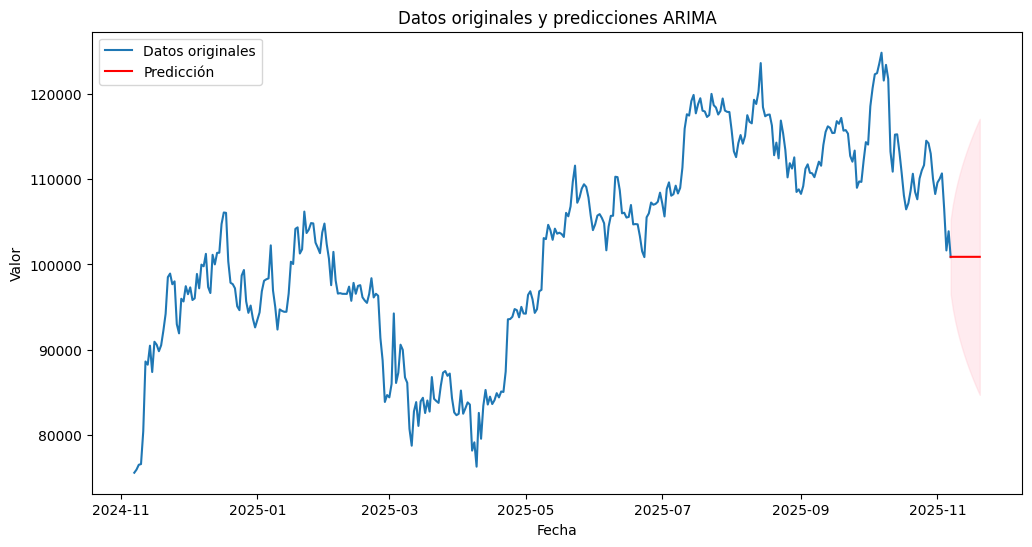

In [ ]:
# Predicciones
pred = model_fit.get_forecast(steps=14)
pred_mean = pred.predicted_mean.values
pred_ci = pred.conf_int()

forecast_index = pd.date_range(start=df.index[-1], periods=14, freq='D')

# Visualización de predicciones
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Valor'], label='Datos originales')
plt.plot(forecast_index, pred_mean, label='Predicción', color='red')
plt.fill_between(forecast_index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Datos originales y predicciones ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()
